# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

Timepoints include both single- and paired-end reads.
- T0: R1, R2, R3, R4 all SingleEnd
- T5: R1 SingleEnd; R2, R3 PairedEnd
- T15: R1 SingleEnd; R2, R3 PairedEnd
- T25: R1 SingleEnd; R2, R3 PairedEnd

In [2]:
# Load data
bulkPathPE = '../nf_output_pE/countData/countData.tsv'
bulkPathSE = '../nf_output_sE/countData/countData.tsv'

metaPathPE = '../Lood_PairedEnd_SraRunTable.csv' # metadata from SRA
metaPathSE = '../Lood_SingleEnd_SraRunTable.csv' # metadata from SRA

gffPath = '../nf_output_pE/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial_PE = pd.read_csv(bulkPathPE, sep = '\t', comment='#', index_col=0)
df_initial_SE = pd.read_csv(bulkPathSE, sep = '\t', comment='#', index_col=0)

metadata_PE = pd.read_csv(metaPathPE)
metadata_SE = pd.read_csv(metaPathSE)

In [4]:
df_initial_PE.head()

,Chr,Start,End,Strand,Length,SRR8948478_sorted.bam,SRR8948479_sorted.bam,SRR8948485_sorted.bam,SRR8948481_sorted.bam,SRR8948484_sorted.bam,SRR8948482_sorted.bam
Geneid,,,,,,,,,,,
gene-PA0001,NC_002516.2,483,2027,+,1545,1852,2543,530,1086,266,1743
gene-PA0002,NC_002516.2,2056,3159,+,1104,655,921,205,473,98,780
gene-PA0003,NC_002516.2,3169,4278,+,1110,1043,1589,188,534,131,692
gene-PA0004,NC_002516.2,4275,6695,+,2421,1736,2730,384,961,270,1304
gene-PA0005,NC_002516.2,7018,7791,-,774,192,510,38,75,31,215


In [5]:
df_initial_SE.head()

,Chr,Start,End,Strand,Length,SRR8948489_sorted.bam,SRR8948488_sorted.bam,SRR8948486_sorted.bam,SRR8948487_sorted.bam,SRR8948483_sorted.bam,SRR8948480_sorted.bam,SRR8948477_sorted.bam
Geneid,,,,,,,,,,,,
gene-PA0001,NC_002516.2,483,2027,+,1545,3121,3116,2269,1630,438,1336,2761
gene-PA0002,NC_002516.2,2056,3159,+,1104,1484,1399,1030,801,239,328,945
gene-PA0003,NC_002516.2,3169,4278,+,1110,1382,1521,1294,754,243,354,1521
gene-PA0004,NC_002516.2,4275,6695,+,2421,3431,2752,2818,1784,433,1107,3021
gene-PA0005,NC_002516.2,7018,7791,-,774,725,645,441,330,101,72,286


In [6]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata_PE

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),infection_time,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study
0,SRR8948478,RNA-Seq,232,1630112132,PRJNA534259,SAMN11482262,797515600,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728471,GSM3733632,5 minutes,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:10:00Z,1,GSM3733632,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
1,SRR8948479,RNA-Seq,224,1568422288,PRJNA534259,SAMN11482261,764277824,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728472,GSM3733633,5 minutes,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:10:00Z,1,GSM3733633,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
2,SRR8948481,RNA-Seq,249,1745869825,PRJNA534259,SAMN11482259,860120632,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728474,GSM3733635,15 minutes,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:10:00Z,1,GSM3733635,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
3,SRR8948482,RNA-Seq,251,1757995756,PRJNA534259,SAMN11482353,881491243,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728475,GSM3733636,15 minutes,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:10:00Z,1,GSM3733636,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
4,SRR8948484,RNA-Seq,250,1754835753,PRJNA534259,SAMN11482351,865772005,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728477,GSM3733638,25 minutes,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:10:00Z,1,GSM3733638,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
5,SRR8948485,RNA-Seq,248,1740421435,PRJNA534259,SAMN11482350,861906961,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728478,GSM3733639,25 minutes,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:10:00Z,1,GSM3733639,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631


In [7]:
metadata_SE

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),infection_time,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study
0,SRR8948477,RNA-Seq,74,1151951438,PRJNA534259,SAMN11482263,506250008,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728470,GSM3733631,5 minutes,Illumina HiSeq 2500,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:11:00Z,1,GSM3733631,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
1,SRR8948480,RNA-Seq,74,1286627266,PRJNA534259,SAMN11482260,580290079,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728473,GSM3733634,15 minutes,Illumina HiSeq 2500,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:11:00Z,1,GSM3733634,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
2,SRR8948483,RNA-Seq,74,1297140513,PRJNA534259,SAMN11482352,591750039,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728476,GSM3733637,25 minutes,Illumina HiSeq 2500,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:11:00Z,1,GSM3733637,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
3,SRR8948486,RNA-Seq,50,340961650,PRJNA534259,SAMN11482349,222837069,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728479,GSM3733640,0 min,Illumina HiSeq 2500,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:08:00Z,1,GSM3733640,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
4,SRR8948487,RNA-Seq,50,398442450,PRJNA534259,SAMN11482258,259594541,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728480,GSM3733641,0 min,Illumina HiSeq 2500,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:08:00Z,1,GSM3733641,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
5,SRR8948488,RNA-Seq,50,430663850,PRJNA534259,SAMN11482257,284001787,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728481,GSM3733642,0 min,Illumina HiSeq 2500,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:08:00Z,1,GSM3733642,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631
6,SRR8948489,RNA-Seq,50,385817600,PRJNA534259,SAMN11482295,253501769,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5728482,GSM3733643,0 min,Illumina HiSeq 2500,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAO1,ILLUMINA,2020-06-05T00:00:00Z,2019-04-24T02:08:00Z,1,GSM3733643,Pseudomonas aeruginosa PAO1 growing exponentia...,SRP193631


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [8]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDictPE = {'GSM3733632': '5_R2', 'GSM3733633': '5_R3',
                'GSM3733635': '15_R2', 'GSM3733636': '15_R3',
                'GSM3733638': '25_R2', 'GSM3733639': '25_R3'
}

sampleDictSE = {'GSM3733640': '0_R1', 'GSM3733641': '0_R2', 'GSM3733642': '0_R3', 'GSM3733643': '0_R4',
                'GSM3733631': '5_R1',
                'GSM3733634': '15_R1',
                'GSM3733637': '25_R1'
}

In [9]:
metadataFullPE = annotateData(metadata_PE, sampleDictPE)
metadataFullSE = annotateData(metadata_SE, sampleDictSE)

Add correct sample names.

In [10]:
dfPE = changeColnames(df_initial_PE.iloc[:,5:df_initial_PE.shape[1]], metadataFullPE)
dfPE = dfPE[['5_R2', '5_R3', '15_R2', '15_R3', '25_R2', '25_R3']]
dfPE

SampleNames,5_R2,5_R3,15_R2,15_R3,25_R2,25_R3
Geneid,,,,,,
gene-PA0001,1852,2543,1086,1743,266,530
gene-PA0002,655,921,473,780,98,205
gene-PA0003,1043,1589,534,692,131,188
gene-PA0004,1736,2730,961,1304,270,384
gene-PA0005,192,510,75,215,31,38
...,...,...,...,...,...,...
gene-EST35_0457,434,11,1848,1443,521,1196
gene-EST35_0458,704,15,4633,4031,1199,2975
gene-EST35_0459,361,11,3294,2671,875,2175


In [11]:
dfSE = changeColnames(df_initial_SE.iloc[:,5:df_initial_SE.shape[1]], metadataFullSE)
dfSE = dfSE[['0_R1', '0_R2', '0_R3', '0_R4', '5_R1', '15_R1', '25_R1']]
dfSE

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,15_R1,25_R1
Geneid,,,,,,,
gene-PA0001,2269,1630,3116,3121,2761,1336,438
gene-PA0002,1030,801,1399,1484,945,328,239
gene-PA0003,1294,754,1521,1382,1521,354,243
gene-PA0004,2818,1784,2752,3431,3021,1107,433
gene-PA0005,441,330,645,725,286,72,101
...,...,...,...,...,...,...,...
gene-EST35_0457,0,0,0,0,202,840,323
gene-EST35_0458,0,0,0,0,1027,3024,466
gene-EST35_0459,0,0,0,0,272,798,207


In [12]:
df = pd.concat([dfSE, dfPE], axis=1)
df.head()

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,15_R1,25_R1,5_R2,5_R3,15_R2,15_R3,25_R2,25_R3
Geneid,,,,,,,,,,,,,
gene-PA0001,2269,1630,3116,3121,2761,1336,438,1852,2543,1086,1743,266,530
gene-PA0002,1030,801,1399,1484,945,328,239,655,921,473,780,98,205
gene-PA0003,1294,754,1521,1382,1521,354,243,1043,1589,534,692,131,188
gene-PA0004,2818,1784,2752,3431,3021,1107,433,1736,2730,961,1304,270,384
gene-PA0005,441,330,645,725,286,72,101,192,510,75,215,31,38


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [13]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [14]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/MK797984.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "MK797984.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
5678,MK797984.1,Genbank,gene,122.0,373.0,.,-,.,gene-EST35_0001,EST35_0001,Gene,protein_coding,EST35_0001,gene-EST35_0001,hypothetical protein,hypothetical protein,No_PHROG,unknown function
5679,MK797984.1,Genbank,gene,408.0,677.0,.,+,.,gene-EST35_0002,EST35_0002,Gene,protein_coding,EST35_0002,gene-EST35_0002,hypothetical protein,hypothetical protein,No_PHROG,unknown function
5680,MK797984.1,Genbank,gene,681.0,986.0,.,+,.,gene-EST35_0003,EST35_0003,Gene,protein_coding,EST35_0003,gene-EST35_0003,hypothetical protein,hypothetical protein,No_PHROG,unknown function
5681,MK797984.1,Genbank,gene,1003.0,1287.0,.,+,.,gene-EST35_0004,EST35_0004,Gene,protein_coding,EST35_0004,gene-EST35_0004,hypothetical protein,hypothetical protein,No_PHROG,unknown function
5682,MK797984.1,Genbank,gene,1290.0,1565.0,.,+,.,gene-EST35_0005,EST35_0005,Gene,protein_coding,EST35_0005,gene-EST35_0005,hypothetical protein,hypothetical protein,No_PHROG,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6134,MK797984.1,Genbank,gene,285321.0,285602.0,.,+,.,gene-EST35_0457,EST35_0457,Gene,protein_coding,EST35_0457,gene-EST35_0457,hypothetical protein,hypothetical protein,No_PHROG,unknown function
6135,MK797984.1,Genbank,gene,285589.0,285873.0,.,+,.,gene-EST35_0458,EST35_0458,Gene,protein_coding,EST35_0458,gene-EST35_0458,hypothetical protein,hypothetical protein,No_PHROG,unknown function
6136,MK797984.1,Genbank,gene,285870.0,286145.0,.,+,.,gene-EST35_0459,EST35_0459,Gene,protein_coding,EST35_0459,gene-EST35_0459,hypothetical protein,hypothetical protein,No_PHROG,unknown function
6137,MK797984.1,Genbank,gene,286146.0,286427.0,.,+,.,gene-EST35_0460,EST35_0460,Gene,protein_coding,EST35_0460,gene-EST35_0460,hypothetical protein,hypothetical protein,No_PHROG,unknown function


In [15]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_002516.2', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [16]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,15_R1,25_R1,5_R2,5_R3,15_R2,15_R3,25_R2,25_R3
Geneid,,,,,,,,,,,,,
gene-PA3105,305,226,402,458,394,117,74,204,433,62,175,19,25
gene-PA0366,87,55,94,100,86,12,71,104,95,30,48,18,9
gene-EST35_0025,0,0,0,0,360,1071,463,971,263,1163,1028,416,862
gene-PA3564,68,46,66,125,112,32,18,41,99,0,12,3,3
gene-PA2070,62,64,93,88,154,75,95,74,92,15,27,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2992,87,78,115,131,99,42,22,64,125,31,49,10,7
gene-PA1848,23,19,29,51,53,24,22,28,30,4,11,1,2
gene-PA4374,167,139,242,265,235,64,73,124,191,30,71,9,5


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [17]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [18]:
tpms = TPM(df_norRNAs, df_initial_PE, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,15_R1,25_R1,5_R2,5_R3,15_R2,15_R3,25_R2,25_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,
gene-PA3105,6.375018,8.587945,8.214101,9.681008,4.887656,1.292880,0.946445,4.311338,9.703269,1.489507,3.953003,0.543420,0.674679,host,xcpQ
gene-PA0366,2.522582,2.907241,2.664361,2.931665,1.480597,0.190019,1.254909,3.043702,2.953244,1.004222,1.509242,0.712262,0.347254,host,gene-PA0366
gene-EST35_0025,0.118549,0.215401,0.115937,0.119952,50.747691,133.958432,66.903117,232.712133,67.014228,315.055053,263.215671,131.878364,259.282538,phage,gene-EST35_0025
gene-PA3564,4.168096,5.141040,3.957244,7.726841,4.064275,1.042751,0.685311,2.551196,6.494250,0.034746,0.820988,0.284411,0.270024,host,gene-PA3564
gene-PA2070,0.975573,1.829323,1.427300,1.397765,1.431830,0.621408,0.907511,1.174856,1.548746,0.276315,0.463332,0.093804,0.108850,host,gene-PA2070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2992,15.832521,25.808487,20.438450,24.075695,10.689281,4.054910,2.478526,11.790992,24.358163,6.509461,9.667786,2.537244,1.720639,host,gene-PA2992
gene-PA1848,0.828627,1.249328,1.017272,1.837424,1.120026,0.455520,0.482995,1.015277,1.153585,0.181216,0.437692,0.070634,0.111768,host,gene-PA1848
gene-PA4374,6.109829,9.245690,8.650674,9.799183,5.100216,1.240578,1.632190,4.588093,7.492760,1.270593,2.815141,0.462774,0.254369,host,gene-PA4374


Log2+1 normalization tpms

In [19]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,15_R1,25_R1,5_R2,5_R3,15_R2,15_R3,25_R2,25_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,
gene-PA3105,2.882647,3.261222,3.203843,3.416976,2.557693,1.197161,0.960842,2.409075,3.419980,1.315860,2.308303,0.626131,0.743884,host,xcpQ
gene-PA0366,1.816633,1.966150,1.873561,1.975140,1.310687,0.250985,1.173069,2.015677,1.983037,1.003042,1.327251,0.775904,0.430022,host,gene-PA0366
gene-EST35_0025,0.161628,0.281433,0.158255,0.163437,5.693423,7.076371,6.085406,7.868589,6.087765,8.304032,8.045572,7.053962,8.023935,phage,gene-EST35_0025
gene-PA3564,2.369633,2.618483,2.309538,3.125459,2.340356,1.030514,0.753015,1.828305,2.905784,0.049277,0.864722,0.361107,0.344855,host,gene-PA3564
gene-PA2070,0.982271,1.500457,1.279352,1.261690,1.282043,0.697247,0.931692,1.120920,1.349788,0.351984,0.549257,0.129355,0.149064,host,gene-PA2070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2992,4.073179,4.744618,4.422129,4.648218,3.547114,2.337685,1.798476,3.677056,4.664378,2.908709,3.415189,1.822626,1.443946,host,gene-PA2992
gene-PA1848,0.870761,1.169494,1.012405,1.504582,1.084082,0.541535,0.568514,1.010978,1.106740,0.240273,0.523755,0.098465,0.152856,host,gene-PA1848
gene-PA4374,2.829815,3.356945,3.270630,3.432850,2.608860,1.163871,1.396263,2.482356,3.086233,1.183069,1.931736,0.548707,0.326961,host,gene-PA4374


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [20]:
columnOrder = ['0_R1', '0_R2', '0_R3', '0_R4', '5_R1', '5_R2', '5_R3', '15_R1', '15_R2', '15_R3', '25_R1', '25_R2', '25_R3']

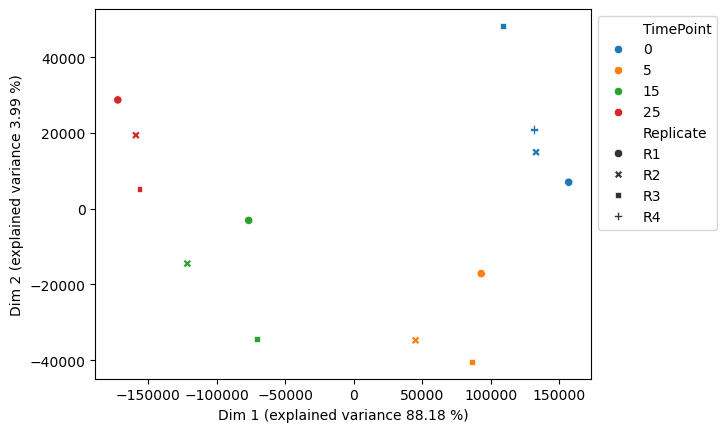

In [21]:
txPCA(tpms[columnOrder])

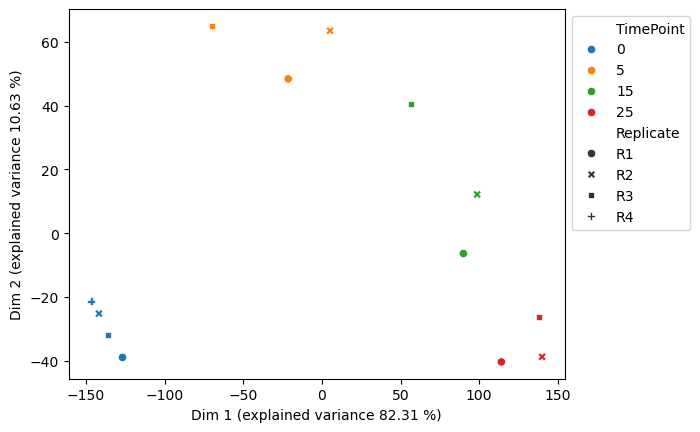

In [22]:
txPCA(logTPMs[columnOrder])

In [23]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

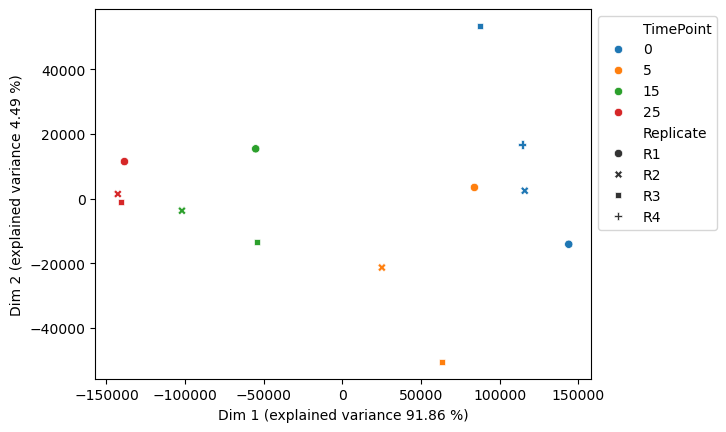

In [24]:
txPCA(tpmHost[columnOrder])

tpmPhage

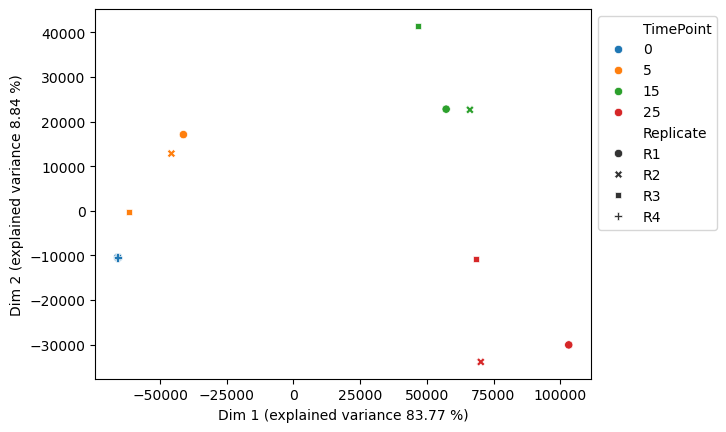

In [25]:
txPCA(tpmPhage[columnOrder])

logTPM Host

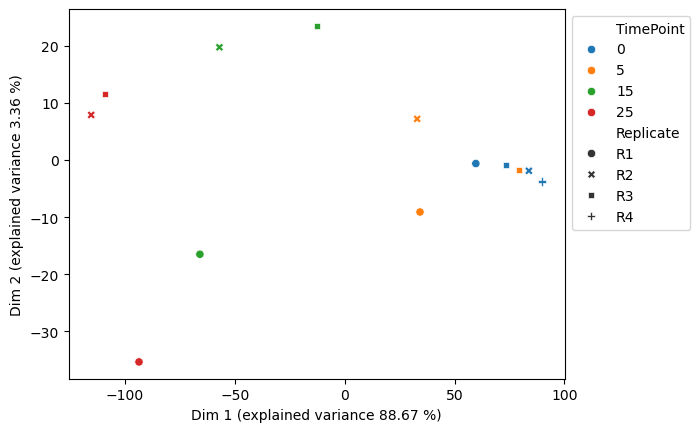

In [26]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

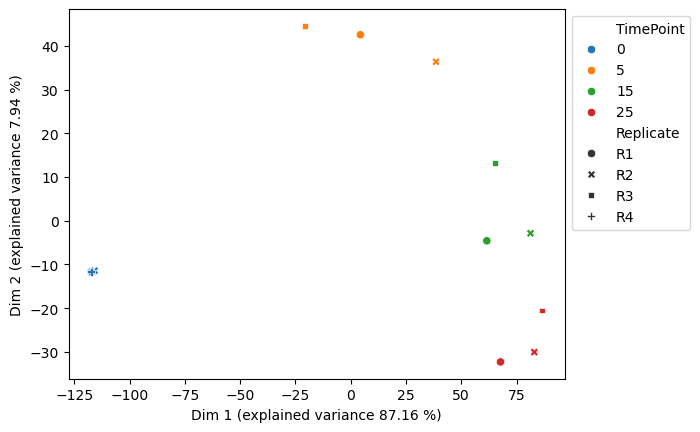

In [27]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ In logTPMs host differentiation between single- and paired-end reads possible, R1 of T15 and T25 off, however only in dim2. So decided to keep all replicates.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [28]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '5', '15', '25']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,5,15,25,Entity,Symbol
Geneid,,,,,,
gene-PA3105,8.214518,6.300754,2.245130,0.721515,host,xcpQ
gene-PA0366,2.756462,2.492514,0.901161,0.771475,host,gene-PA0366
gene-EST35_0025,0.142460,116.824684,237.409719,152.688006,phage,gene-EST35_0025
gene-PA3564,5.248305,4.369907,0.632829,0.413249,host,gene-PA3564
gene-PA2070,1.407490,1.385144,0.453685,0.370055,host,gene-PA2070
...,...,...,...,...,...,...
gene-PA2992,21.538788,15.612812,6.744052,2.245470,host,gene-PA2992
gene-PA1848,1.233163,1.096296,0.358143,0.221799,host,gene-PA1848
gene-PA4374,8.451344,5.727023,1.775438,0.783111,host,gene-PA4374


In [29]:
TPMsds = TPMsds[['0', '5', '15', '25']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,5,15,25,Entity,Symbol
Geneid,,,,,,
gene-PA3105,1.190987,2.417418,1.210313,0.167834,host,xcpQ
gene-PA0366,0.170743,0.716486,0.543478,0.372907,host,gene-PA0366
gene-EST35_0025,0.042137,82.213444,76.150977,79.905116,phage,gene-EST35_0025
gene-PA3564,1.499028,1.624187,0.432490,0.192467,host,gene-PA3564
gene-PA2070,0.302069,0.156169,0.141049,0.380088,host,gene-PA2070
...,...,...,...,...,...,...
gene-PA2992,3.822252,6.200232,2.297444,0.371885,host,gene-PA2992
gene-PA1848,0.379358,0.058905,0.125318,0.185455,host,gene-PA1848
gene-PA4374,1.411566,1.265948,0.735283,0.606388,host,gene-PA4374


In [30]:
propExp = proportionalExp(TPMmeans[['0', '5', '15', '25']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,5,15,25,Entity,Symbol
Geneid,,,,,,
gene-PA3105,1.000000,0.767027,0.273312,0.087834,host,xcpQ
gene-PA0366,1.000000,0.904244,0.326927,0.279879,host,gene-PA0366
gene-EST35_0025,0.000600,0.492080,1.000000,0.643141,phage,gene-EST35_0025
gene-PA3564,1.000000,0.832632,0.120578,0.078739,host,gene-PA3564
gene-PA2070,1.000000,0.984124,0.322336,0.262919,host,gene-PA2070
...,...,...,...,...,...,...
gene-PA2992,1.000000,0.724870,0.313112,0.104252,host,gene-PA2992
gene-PA1848,1.000000,0.889012,0.290426,0.179862,host,gene-PA1848
gene-PA4374,1.000000,0.677646,0.210078,0.092661,host,gene-PA4374


## 5. Phage gene classification

Similar to Sprenger VP882_WT, no classification specified in paper. Thus 0 -> early, 30 -> middle, 60 -> late.

In [31]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [32]:
# # Export fractional expressions with T=0.6 + Host/Phage Annotation for Orthofinder Analysis
# t = classLabelThreshold(propExp)
# t = t[t["Entity"] == "phage"]
# t["Host"] = "Pseudomonas_aeruginosa_PAO1"
# t["Phage"] = "Pseudomonas_phage_vB_PaeM_PA5oct"
# t.to_csv("/ceph/ibmi/studenten/waffen/Cross_Analysis/Orthofinder_Clustering/Fractional_Expressions/T060/Lood_fractional_expression_T=0.6.tsv", sep="\t")

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [34]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [35]:
TPMmeans[TPMmeans['Entity'] == 'phage']

,0,5,15,25,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,
gene-EST35_0025,0.142460,116.824684,237.409719,152.688006,phage,gene-EST35_0025,early,middle
gene-EST35_0006,0.093894,218.668085,577.916406,417.533517,phage,gene-EST35_0006,early,middle
gene-EST35_0224,0.017214,7.282511,129.307101,1425.406981,phage,gene-EST35_0224,late,late
gene-EST35_0426,0.131154,66.775785,384.101384,876.294556,phage,gene-EST35_0426,middle,late
gene-EST35_0276,0.023950,71.676267,1603.572527,4620.958850,phage,gene-EST35_0276,middle,late
...,...,...,...,...,...,...,...,...
gene-EST35_0074,0.127118,2021.895596,1833.146239,916.067207,phage,gene-EST35_0074,early,early
gene-EST35_0354,0.192155,3.736643,7.372639,2.805928,phage,gene-EST35_0354,early,middle
gene-EST35_0181,0.098365,95.106256,1833.242189,2097.632116,phage,gene-EST35_0181,middle,late


In [36]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      236
middle    183
early      42
Name: count, dtype: int64

Add classes to other dfs.

In [37]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NC_002516.2']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'MK797984.1']
gff3_genes["seq_id"].unique()

array(['NC_002516.2', 'MK797984.1'], dtype=object)

## 6. Add variance to all dataframes

Base variance call on tpms.

In [38]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [39]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,15_R1,25_R1,5_R2,5_R3,15_R2,15_R3,25_R2,25_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,
gene-PA3105,6.375018,8.587945,8.214101,9.681008,4.887656,1.292880,0.946445,4.311338,9.703269,1.489507,3.953003,0.543420,0.674679,host,xcpQ,None,None,2.478204
gene-PA0366,2.522582,2.907241,2.664361,2.931665,1.480597,0.190019,1.254909,3.043702,2.953244,1.004222,1.509242,0.712262,0.347254,host,gene-PA0366,None,None,0.580502
gene-EST35_0025,0.118549,0.215401,0.115937,0.119952,50.747691,133.958432,66.903117,232.712133,67.014228,315.055053,263.215671,131.878364,259.282538,phage,gene-EST35_0025,early,middle,104.360686
gene-PA3564,4.168096,5.141040,3.957244,7.726841,4.064275,1.042751,0.685311,2.551196,6.494250,0.034746,0.820988,0.284411,0.270024,host,gene-PA3564,None,None,2.150050
gene-PA2070,0.975573,1.829323,1.427300,1.397765,1.431830,0.621408,0.907511,1.174856,1.548746,0.276315,0.463332,0.093804,0.108850,host,gene-PA2070,None,None,0.333191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2992,15.832521,25.808487,20.438450,24.075695,10.689281,4.054910,2.478526,11.790992,24.358163,6.509461,9.667786,2.537244,1.720639,host,gene-PA2992,None,None,6.002969
gene-PA1848,0.828627,1.249328,1.017272,1.837424,1.120026,0.455520,0.482995,1.015277,1.153585,0.181216,0.437692,0.070634,0.111768,host,gene-PA1848,None,None,0.333700
gene-PA4374,6.109829,9.245690,8.650674,9.799183,5.100216,1.240578,1.632190,4.588093,7.492760,1.270593,2.815141,0.462774,0.254369,host,gene-PA4374,None,None,2.491997


In [40]:
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

In [41]:
tpms

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,15_R1,25_R1,5_R2,5_R3,15_R2,15_R3,25_R2,25_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,
gene-PA3105,6.375018,8.587945,8.214101,9.681008,4.887656,1.292880,0.946445,4.311338,9.703269,1.489507,3.953003,0.543420,0.674679,host,xcpQ,None,None,2.478204
gene-PA0366,2.522582,2.907241,2.664361,2.931665,1.480597,0.190019,1.254909,3.043702,2.953244,1.004222,1.509242,0.712262,0.347254,host,gene-PA0366,None,None,0.580502
gene-EST35_0025,0.118549,0.215401,0.115937,0.119952,50.747691,133.958432,66.903117,232.712133,67.014228,315.055053,263.215671,131.878364,259.282538,phage,gene-EST35_0025,early,middle,104.360686
gene-PA3564,4.168096,5.141040,3.957244,7.726841,4.064275,1.042751,0.685311,2.551196,6.494250,0.034746,0.820988,0.284411,0.270024,host,gene-PA3564,None,None,2.150050
gene-PA2070,0.975573,1.829323,1.427300,1.397765,1.431830,0.621408,0.907511,1.174856,1.548746,0.276315,0.463332,0.093804,0.108850,host,gene-PA2070,None,None,0.333191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2992,15.832521,25.808487,20.438450,24.075695,10.689281,4.054910,2.478526,11.790992,24.358163,6.509461,9.667786,2.537244,1.720639,host,gene-PA2992,None,None,6.002969
gene-PA1848,0.828627,1.249328,1.017272,1.837424,1.120026,0.455520,0.482995,1.015277,1.153585,0.181216,0.437692,0.070634,0.111768,host,gene-PA1848,None,None,0.333700
gene-PA4374,6.109829,9.245690,8.650674,9.799183,5.100216,1.240578,1.632190,4.588093,7.492760,1.270593,2.815141,0.462774,0.254369,host,gene-PA4374,None,None,2.491997


## 7. Write data to output

In [42]:
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,15_R1,25_R1,5_R2,5_R3,15_R2,15_R3,25_R2,25_R3
Geneid,,,,,,,,,,,,,
gene-PA3105,305,226,402,458,394,117,74,204,433,62,175,19,25
gene-PA0366,87,55,94,100,86,12,71,104,95,30,48,18,9
gene-EST35_0025,0,0,0,0,360,1071,463,971,263,1163,1028,416,862
gene-PA3564,68,46,66,125,112,32,18,41,99,0,12,3,3
gene-PA2070,62,64,93,88,154,75,95,74,92,15,27,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2992,87,78,115,131,99,42,22,64,125,31,49,10,7
gene-PA1848,23,19,29,51,53,24,22,28,30,4,11,1,2
gene-PA4374,167,139,242,265,235,64,73,124,191,30,71,9,5


In [43]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs = df_norRNAs[['0_R1', '0_R2', '0_R3', '0_R4', '5_R1', '5_R2', '5_R3', '15_R1', '15_R2', '15_R3', '25_R1', '25_R2', '25_R3', 'Entity', 'Symbol']]
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,25_R1,25_R2,25_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,
gene-PA3105,305,226,402,458,394,204,433,117,62,175,74,19,25,host,xcpQ
gene-PA0366,87,55,94,100,86,104,95,12,30,48,71,18,9,host,gene-PA0366
gene-EST35_0025,0,0,0,0,360,971,263,1071,1163,1028,463,416,862,phage,gene-EST35_0025
gene-PA3564,68,46,66,125,112,41,99,32,0,12,18,3,3,host,gene-PA3564
gene-PA2070,62,64,93,88,154,74,92,75,15,27,95,4,5,host,gene-PA2070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2992,87,78,115,131,99,64,125,42,31,49,22,10,7,host,gene-PA2992
gene-PA1848,23,19,29,51,53,28,30,24,4,11,22,1,2,host,gene-PA1848
gene-PA4374,167,139,242,265,235,124,191,64,30,71,73,9,5,host,gene-PA4374


In [44]:
tpms = tpms[['0_R1', '0_R2', '0_R3', '0_R4', '5_R1', '5_R2', '5_R3', '15_R1', '15_R2', '15_R3', '25_R1', '25_R2', '25_R3', 'Entity', 'Symbol', 'ClassThreshold', 'ClassMax', 'Variance']]
tpms

SampleNames,0_R1,0_R2,0_R3,0_R4,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,25_R1,25_R2,25_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,
gene-PA3105,6.375018,8.587945,8.214101,9.681008,4.887656,4.311338,9.703269,1.292880,1.489507,3.953003,0.946445,0.543420,0.674679,host,xcpQ,None,None,2.478204
gene-PA0366,2.522582,2.907241,2.664361,2.931665,1.480597,3.043702,2.953244,0.190019,1.004222,1.509242,1.254909,0.712262,0.347254,host,gene-PA0366,None,None,0.580502
gene-EST35_0025,0.118549,0.215401,0.115937,0.119952,50.747691,232.712133,67.014228,133.958432,315.055053,263.215671,66.903117,131.878364,259.282538,phage,gene-EST35_0025,early,middle,104.360686
gene-PA3564,4.168096,5.141040,3.957244,7.726841,4.064275,2.551196,6.494250,1.042751,0.034746,0.820988,0.685311,0.284411,0.270024,host,gene-PA3564,None,None,2.150050
gene-PA2070,0.975573,1.829323,1.427300,1.397765,1.431830,1.174856,1.548746,0.621408,0.276315,0.463332,0.907511,0.093804,0.108850,host,gene-PA2070,None,None,0.333191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2992,15.832521,25.808487,20.438450,24.075695,10.689281,11.790992,24.358163,4.054910,6.509461,9.667786,2.478526,2.537244,1.720639,host,gene-PA2992,None,None,6.002969
gene-PA1848,0.828627,1.249328,1.017272,1.837424,1.120026,1.015277,1.153585,0.455520,0.181216,0.437692,0.482995,0.070634,0.111768,host,gene-PA1848,None,None,0.333700
gene-PA4374,6.109829,9.245690,8.650674,9.799183,5.100216,4.588093,7.492760,1.240578,1.270593,2.815141,1.632190,0.462774,0.254369,host,gene-PA4374,None,None,2.491997


In [45]:
# Full TPM table
tpms.to_csv('Lood_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Lood_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Lood_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Lood_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Lood_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Lood_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Lood_phage_gff3.tsv', sep='\t')